# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Wei-Kuang 

Last Name: :Lin

Student ID: 997062562

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

##### Lesson_13_Notebook  : SQL with Pandas

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd         # conda install -c conda-forge geopandas
import osmnx as ox              # conda install -c conda-forge osmnx
import shapely.geometry as geom # conda install -c conda-forge shapely

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
%matplotlib inline
plt.style.use('ggplot')

In [4]:
import matplotlib.patches as mpatches

In [5]:
# Let's create the sqlite file, and create the connection.
sqlite_file = 'C:/Users/WeiKuang/Documents/GitHub/data/sf_data.sqlite'
sf_conn = sqla.create_engine('sqlite:///' + sqlite_file)    # sf_conn is the connection between SQL and python

In [6]:
# Select the talbe "mobile_food_locations" from the "sf_data.sqlite (sf_conn)"
location = pd.read_sql_query("""select * from mobile_food_locations""",sf_conn)

In [7]:
permits = pd.read_sql(""" select * from mobile_food_permits
                    where Status = 'APPROVED' """,sf_conn)

In [8]:
schedule = pd.read_sql_query("select * from mobile_food_schedule",sf_conn)

##### My Results

In [9]:
# Exampel of aggregate, distinct 
resutlt = pd.read_sql("""select T1.permit, count(distinct locationid) as count
                         from (mobile_food_schedule T1 join mobile_food_permits T2 on T1.permit = T2.permit) 
                         where status = 'APPROVED'
                         group by T1.permit 
                         order by count DESC
                         """,sf_conn)
resutlt.head(10)

,permit,count
0,16MFF-0051,23
1,16MFF-0037,17
2,16MFF-0027,13
3,16MFF-0069,10
4,16MFF-0019,7
5,16MFF-0053,7
6,17MFF-0125,7
7,16MFF-0047,5
8,16MFF-0046,4
9,16MFF-0096,4


In [11]:
resutlt2 = pd.read_sql("""select permit, Applicant from mobile_food_permits
                          where permit = "16MFF-0051"
                       """,sf_conn)

resutlt2

,permit,Applicant
0,16MFF-0051,Park's Catering


#### ----------------------------

#### Ans to Exercise 1.1. (20 pts) Which mobile food vendor(s) sells at the most locations?
Park's Catering ( permit id 16MFF-0051) is the mobile food vendor that sells at the most locatoins.

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

#### 1.2.1 Which parts of the city are the most and least expensive?

In [12]:
housing = pd.read_sql_query("""select * from zillow""",sf_conn)
housing = housing[['RegionName','Date','MedianSoldPricePerSqft_AllHomes']]
housing = housing.dropna(axis=0, how='any')  # remove the row(axis =0) if the row contians any NA. 
#housing.tail(3)

In [13]:
# convert Date to real "Date" data
housing['Date'] = pd.to_datetime(housing["Date"])

In [14]:
# RegionNmae unquie list
SF_code = housing['RegionName'].unique().tolist()

In [15]:
SoldPrice = pd.DataFrame()

for i in SF_code:
    df = housing[housing['RegionName'] == i]       # Select one zipcode at a time
    df1 = df [ df['Date'] == df['Date'].max() ]    # Then, select its most recent data
    SoldPrice = SoldPrice.append(df1, ignore_index=True)
    
SoldPrice = SoldPrice.sort_values(by=['MedianSoldPricePerSqft_AllHomes'])
#SoldPrice.head(5)

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd         # conda install -c conda-forge geopandas
import osmnx as ox              # conda install -c conda-forge osmnx
import shapely.geometry as geom # conda install -c conda-forge shapely

In [8]:
# counties = gpd.read_file("shapefiles/counties/cb_2016_us_county_500k.shp")
Geo_US = gpd.read_file("C:/Users/WeiKuang/Documents/GitHub/data/us_zip/cb_2016_us_zcta510_500k.shp")

In [7]:
Geo_US

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,21914,8600000US21914,21914,1924479,477175,"POLYGON ((-75.99444799999999 39.567742, -75.99..."
1,01001,8600000US01001,01001,29731610,2118827,"POLYGON ((-72.667677 42.045022, -72.657715 42...."
2,34736,8600000US34736,34736,322808220,78588518,"(POLYGON ((-81.806163 28.568643, -81.801577999..."
3,46151,8600000US46151,46151,530632048,9804480,"(POLYGON ((-86.398562 39.320829, -86.398125999..."
4,48039,8600000US48039,48039,59592687,4845242,"POLYGON ((-82.61060000000001 42.724669, -82.51..."
5,01521,8600000US01521,01521,31832963,1990946,"POLYGON ((-72.20119199999999 42.044402, -72.19..."
6,49892,8600000US49892,49892,421838378,8959024,"POLYGON ((-87.95137299999999 45.907502, -87.94..."
7,70639,8600000US70639,70639,177328877,1814507,"POLYGON ((-93.57820699999999 30.999995, -93.57..."
8,56755,8600000US56755,56755,124397913,566871,"POLYGON ((-97.239209 48.968684, -97.23796 48.9..."
9,64723,8600000US64723,64723,116917337,974138,"POLYGON ((-94.61334164789089 38.4068920110898,..."


In [18]:
Keep = []
for x in SF_code:
    s = str(x)
    Keep = Keep + [s]
    
Keep.remove('94080')

In [19]:
SF =  US_zip[ US_zip.GEOID10.isin(Keep)]
SF.head(3)

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
102,94102,8600000US94102,94102,1732307,0,"POLYGON ((-122.429929 37.777909, -122.426829 3..."
1041,94116,8600000US94116,94116,6699045,97204,"POLYGON ((-122.510297 37.764073, -122.509833 3..."
1499,94158,8600000US94158,94158,1703879,1342698,"POLYGON ((-122.397866 37.772323, -122.396381 3..."


In [20]:
#df[['col2','col3']] = df[['col2','col3']].apply(pd.to_numeric)
SF['GEOID10'] = pd.to_numeric(SF['GEOID10'])                     

C:\Users\WeiKuang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
# joint
merged = SoldPrice.merge(SF, left_on='RegionName', right_on='GEOID10', how='inner' )

In [22]:
# Conver it back to GeoDataFrame in order to plot
Price_shape = gpd.GeoDataFrame(merged)

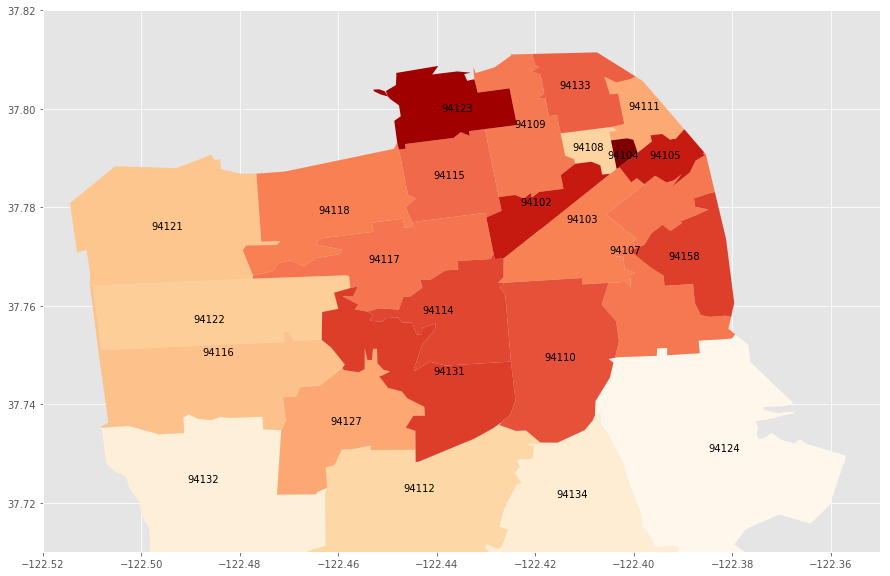

In [73]:
# Make the plot. Choropleth map Maps
ax = Price_shape.plot(column = "MedianSoldPricePerSqft_AllHomes", cmap = "OrRd", figsize = (15, 15))
#Price_shape.plot(ax = ax)

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.82])

# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.RegionName, xy = coords, horizontalalignment = "center")
    
# Call add_label() on each row.
Price_shape.apply(add_label, axis = 1)

# Don't print out the result from the .apply().
plt.show()

####  Report: Which parts of the city are the most and least expensive?
1. The color of each shape is based on the value of an associated median sold price per square feet. The darker the color is, the more expensive the area is. The most recent median sold price of that area is chosen to be analyzed. The range of the median sold price is from 1336.12 to 583.53 dollars. 

2. The zip code - 94104 is the most expensive area, which is the financial district of San Francisco. Its median sold price per square feet is 1336.12 dollars, according to the most recent record on 2007-10-01.

3. In contrast, the zip code -94124, including Bayview, Hunters Point, India Basin, Islais Creek, and Silver Terrace district is the least expensive area. Its median sold price per square feet is 583.53 dollars, according to the most recent record on 2016-05-01.

4. The choropleth map shows that northeast areas tend to be more expensive than south areas in San Francisco.


#### 1.2.2  Which parts of the city are the most dangerous (and at what times)?

In [24]:
crime = pd.read_sql_query("""select * from crime""",sf_conn)
#crime.head()
crime['Datetime'] = pd.to_datetime(crime['Datetime'])

In [25]:
# The most dangerous area: SOUTHERN
CrimeCount = crime.groupby(['PdDistrict'])['IncidntNum'].count()  # size() works also
CrimeCount = pd.DataFrame(CrimeCount )
CrimeCount.columns= ['CrimeCount']
CrimeCount.insert(0,"PdDistrict", CrimeCount.index)
CrimeCount = CrimeCount.reset_index(drop=True)
CrimeCount[ CrimeCount['CrimeCount'] == CrimeCount['CrimeCount'].max() ]

,PdDistrict,CrimeCount
7,SOUTHERN,196178


C:\Users\WeiKuang\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


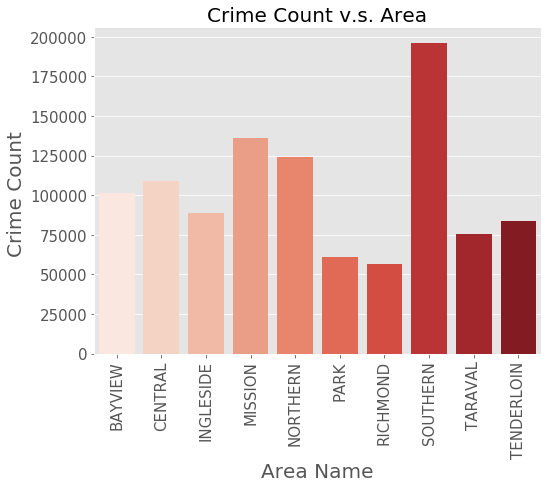

In [26]:
# plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

f, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

sns.barplot( x='PdDistrict' , y='CrimeCount', data = CrimeCount, palette="Reds",ax=ax1)

plt.title('Crime Count v.s. Area',fontsize=20 )

plt.xticks(fontsize=10)
plt.yticks(fontsize=15)

plt.xlabel("Area Name", fontsize=20)
plt.ylabel("Crime Count ", fontsize=20)

plt.xticks(rotation=90, fontsize=15)

plt.show()

In [27]:
# subset the SOUTHERN
SOUTHERN = crime[ crime['PdDistrict'] == 'SOUTHERN' ]

In [28]:
# Most dangerous time at SOUTHERN
CrimeTime = SOUTHERN.groupby([SOUTHERN.Datetime.map(lambda t: t.hour)]).count()
CrimeTime.insert(0,'Hour',CrimeTime.index)
CrimeTime= CrimeTime[['Hour','IncidntNum']].reset_index(drop= True)
CrimeTime.columns=['Hour','CrimeCount']

In [29]:
CrimeTime = CrimeTime.sort_values(by=['CrimeCount'],ascending=False)

C:\Users\WeiKuang\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


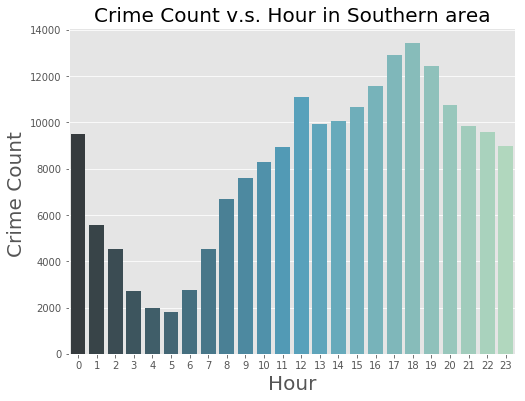

In [30]:
#plot
f, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

#sns.barplot( Rank.loc[:,'food'] , Rank.loc[:,'Best_Combination'], palette="GnBu_d")
sns.barplot( x='Hour' , y='CrimeCount', data = CrimeTime, palette="GnBu_d",ax=ax1)

plt.title('Crime Count v.s. Hour in Southern area',fontsize=20 )

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Hour", fontsize=20)
plt.ylabel("Crime Count ", fontsize=20)

plt.show()

In [31]:
# What are the most common types of the crime happens in SOUTHERN during the noon and between 17pm and 19pm.
Result3 = pd.read_sql("""select Category,Datetime,PdDistrict, Lon,Lat,
                            count(Category) as count
                            from crime
                            WHERE PdDistrict = 'SOUTHERN' 
                            and ( strftime('%H',Datetime) = "12" or strftime('%H',Datetime) = "17" or strftime('%H',Datetime) = "18" or strftime('%H',Datetime) = "19" )
                            and Category != "NON-CRIMINAL" 
                            and Category != "OTHER OFFENSES"
                            group by Category
                            order by count DESC
                        """,sf_conn)

Result3.head(3)

,Category,Datetime,PdDistrict,Lon,Lat,count
0,LARCENY/THEFT,2016-02-05 17:25:00,SOUTHERN,-122.405295,37.786307,18081
1,ASSAULT,2016-10-16 17:10:00,SOUTHERN,-122.412515,37.780478,3215
2,WARRANTS,2016-11-22 12:55:00,SOUTHERN,-122.410417,37.772723,2580


#### Report: 1.2.2 Which parts of the city are the most dangerous (and at what times)?
1. Based on the crime data from Jan. 2015 to Aug. 2016, SOUTHERN has the highest number of crime as 196178. Areas with the second and thrid highest number of crimes are MISSION and NORTHERN, respectively, as shown in the histogram of "Crime Count v.s. Area". 

2. In the SOUTHERN area, most of the crime happens during 18:00 to 19:00. Also, the number of crime peaks at 12:00, as shown in the histogram of "Crime Count v.s. The hour in the Southern area". 

3. During the most dangerous time (noon and evening from 17 to 19 pm), the top three common categories of crime are "LARCENY/THEFT", "ASSAULT", and "WARRANTS".

4. Finally, this brief report suggests that residents who live in the southern area need to be vigilant for LARCENY/THEFT during the most dangerous times, such as noon and evening(17-19 pm).

##### ----------------------------------------------------------------------

#### 1.2.3 Are noise complaints and mobile food vendors related?

In [32]:
noise = pd.read_sql_query("""select * from noise""",sf_conn)
noise.head()
noise.shape

(4795, 7)

In [33]:
# Chekc how many noise cause by mobile_food_facility
noise_type = pd.read_sql("""select Type, Datetime, count(Type) as count 
                            from noise
                            where Type = 'mobile_food_facility'
                            group by Type
                         """,sf_conn)

noise_type
# noise['Type'].unique().tolist()

,Type,Datetime,count
0,mobile_food_facility,2016-11-03 16:41:55,7


In [34]:
#When are noise compliants the most
noise_time = pd.read_sql("""select CaseID, Datetime , 
                            strftime("%H",Datetime) as Hour,
                            count(CaseID) as count
                            
                            from noise
                            group by Hour 
                            order by count DESC
                            """,sf_conn)
noise_time.head(3)

,CaseID,Datetime,Hour,count
0,6688230,2017-01-03 23:07:01,23,384
1,6684062,2017-01-02 22:09:55,22,373
2,6689094,2017-01-04 09:19:11,09,260


C:\Users\WeiKuang\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


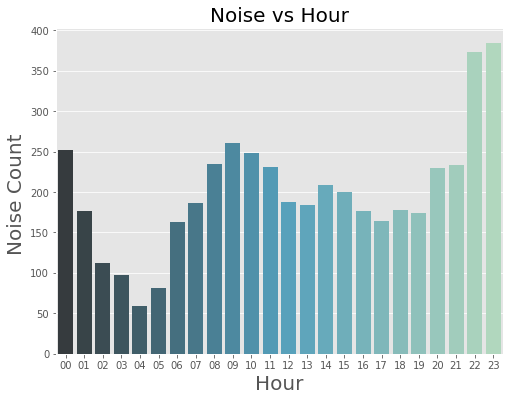

In [35]:
#plot
f, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

#sns.barplot( Rank.loc[:,'food'] , Rank.loc[:,'Best_Combination'], palette="GnBu_d")
sns.barplot( x='Hour' , y='count', data = noise_time, palette="GnBu_d",ax=ax1)

plt.title('Noise vs Hour',fontsize=20 )

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Hour", fontsize=20)
plt.ylabel("Noise Count ", fontsize=20)

plt.show()

In [36]:
# Convert Noise to a GeoPanda Data Frame
Inglat = [ geom.Point (x) for x in zip (noise.Lon, noise.Lat)]
Noise_Geo = gpd.GeoDataFrame(noise, geometry = Inglat)

In [37]:
# Convert food locaitons to a GeoPanda Data Frame
FoodLoc = pd.read_sql_query("""select * from mobile_food_locations""",sf_conn)
Inglat = [ geom.Point (x) for x in zip (FoodLoc.Longitude, FoodLoc.Latitude)]
Food_Loc_Geo = gpd.GeoDataFrame(FoodLoc, geometry = Inglat)

In [75]:
MobilFood_Noise_Geo = Noise_Geo.loc [Noise_Geo.Type == 'mobile_food_facility']

In [39]:
# SF shape
SF_shape = gpd.read_file("C:/Users/WeiKuang/Documents/GitHub/data/SF_zip/geo_export_b8d0ed93-730c-44ae-8d05-66a86114a164.shp")

(37.71, 37.84)

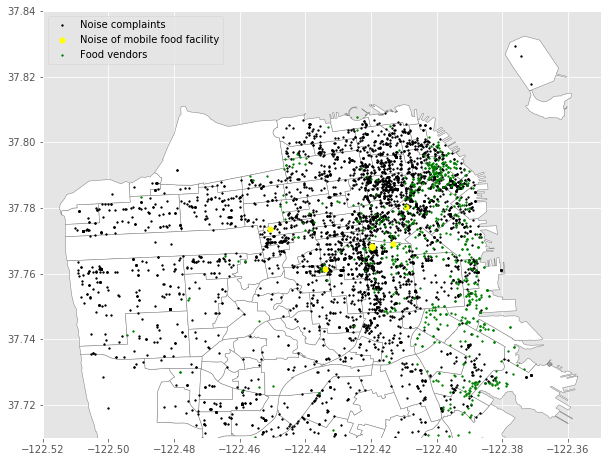

In [89]:
# Price_ax = Price_shape.plot(column = "MedianSoldPricePerSqft_AllHomes", cmap = "OrRd", figsize = (15, 15))
ax = SF_shape.plot(color ="white" , edgecolor ="gray" , figsize = (10, 10))
Noise_Geo.plot(ax= ax, color= "black", markersize=3, label="Noise complaints")
MobilFood_Noise_Geo.plot(ax = ax, color ='yellow', markersize=30, label="Noise of mobile food facility" )
Food_Loc_Geo.plot(ax= ax, color= 'green', markersize=3, label="Food vendors")

plt.legend(loc=2)

ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

#### Ans to "Are noise complaints and mobile food vendors related?"
1. The black dots are noise complaints. Yellow dots are noise complaints caused by mobile food facility. Green dots are the location of all kinds of food vendors. 
2. Food vendors mostly located on business area and main streets, and noise complaints seem to locate on non-business areas. 
3. Second, a small number of noise complaints are caused by "mobile_food_facility". There are only seven noise complaints about mobile_food_facility, comparing to 4795 ( the total noise complaints).
4. Third, my investigation in times of noise shows that most of the noise complaints occurred between 22 and 23 pm in which fewer food vendors operate their business. 
5. Thus, the relationship between noise complaints and food vendors seems to be very weak.

##### -----------------------------------------------------

##### 1.2.4 My curiosity: What are the times in which most food vendors are avaliable?

In [90]:
# Get the approved permit
permits = pd.read_sql(""" select * from mobile_food_permits
                          where Status = 'APPROVED' """,sf_conn)

In [91]:
# Get the permit of Truck
Truck_permits = pd.read_sql(""" select * from mobile_food_permits
                                where Status = 'APPROVED' and FacilityType = 'Truck' """,sf_conn)
Truck_permits = Truck_permits.permit
Truck_permits = Truck_permits.unique().tolist()

In [92]:
# Subset
schedule=pd.read_sql_query("select * FROM mobile_food_schedule",sf_conn)
Truck_hour = schedule[ schedule.permit.isin(Truck_permits) ] 

In [93]:
Truck_hour = Truck_hour.reset_index(drop= True)
Truck_hour.shape

(691, 5)

In [94]:
# creat a list reflect the business hours for each food truck
H=[]
n,p = Truck_hour.shape

for i in range(n) :
    if  Truck_hour['StartHour'][i] < Truck_hour['EndHour'][i]:
        H= H + [np.linspace(Truck_hour['StartHour'][i], Truck_hour['EndHour'][i], Truck_hour['EndHour'][i] - Truck_hour['StartHour'][i]+1)]
    else :
        T1 = np.linspace(Truck_hour['StartHour'][i], 23, 23- Truck_hour['StartHour'][i]+1)
        T2 = np.linspace(0,Truck_hour['EndHour'][i], Truck_hour['EndHour'][i]+1)
        T3 = np.concatenate((T1, T2), axis=0)
        H= H + [T3] 
        
H[0:3]

[array([10., 11., 12., 13., 14.]),
 array([10., 11., 12., 13., 14.]),
 array([10., 11., 12., 13., 14.])]

In [95]:
# Creat an initial Dataframe
d= {'0_Hour': [x for x in range(24)], '1_Count': [x for x in range(24)]}
DF= pd.DataFrame(data=d)

In [96]:
# use for loop to
n,p = Truck_hour.shape
for h in range(0,24):
    count=0
    for i in range(n):    # this range correspondes to the length of H
        if h in H[i]:
            count = count+1
            
        DF.iloc[h,0] = h      # assign value to hour
        DF.iloc[h,1] = count  # assign value to count

In [97]:
DF.head()

,0_Hour,1_Count
0,0,98
1,1,65
2,2,65
3,3,58
4,4,61


C:\Users\WeiKuang\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


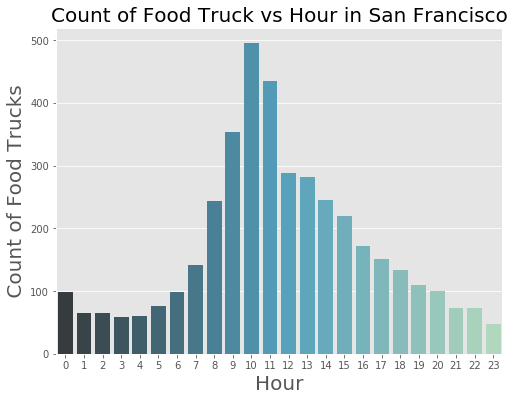

In [98]:
#plot
f, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

#sns.barplot( Rank.loc[:,'food'] , Rank.loc[:,'Best_Combination'], palette="GnBu_d")
sns.barplot( x='0_Hour' , y='1_Count', data = DF, palette="GnBu_d",ax=ax1)

plt.title('Count of Food Truck vs Hour in San Francisco',fontsize=20 )

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Hour", fontsize=20)
plt.ylabel(" Count of Food Trucks ", fontsize=20)

plt.show()

#### ANS to "What are the times in which most food vendors are avaliable?"
1. First, the approved food trucks were selected from the database. 
2. Second, based on StartHour and EndHour, an array of the business hour was created. For example, Business hour 9-13 is denoted as [9,10,11,12,13]
3. Then, I use for loop to count the number of hours appear in the business hours.
4. The result reveals that most food trucks are available during 10 and 11 am in general. Thus, this period might be the best time to find food trucks.

##### ----------------------------------

##### 1.2.5 My curiosity:  Are the schools in the safe area (that is, the area has lower crime count) ?

In [150]:
# Convert School to a GeoPanda Data Frame
Inglat_sch = [ geom.Point (x) for x in zip (schools.Lon, schools.Lat)]
Schools_Geo = gpd.GeoDataFrame(schools, geometry = Inglat_sch)

In [151]:
# Subset Elementary school
Ele_Sch_Geo = Schools_Geo [Schools_Geo.Name.str.contains('Elementary') ]

In [152]:
#Convert Crime to a GeoPanda Frame
Inglat_crime = [ geom.Point (x) for x in zip (crime.Lon, crime.Lat)]
Crime_Geo = gpd.GeoDataFrame(crime, geometry = Inglat_crime)

In [205]:
# Select the crime related to the safety of children 
crime_time = pd.read_sql("""select * from crime
                            WHERE strftime('%H',Datetime) between '10' and '18'
                            and Category = 'SEX OFFENSES, FORCIBLE'
                            or Category = 'SEX OFFENSES, NON FORCIBLE'
                            or Category = 'KIDNAPPING'
                            or Category = 'WEAPON LAWS'
                        """,sf_conn)

In [206]:
# Convert Crime to a GeoPanda Frame
Inglat_crime_time = [ geom.Point (x) for x in zip (crime_time.Lon, crime_time.Lat)]
Crime_Time_Geo = gpd.GeoDataFrame(crime_time, geometry = Inglat_crime_time)

In [224]:
# Subset the type of crime
Sex_Crime = Crime_Time_Geo[ Crime_Time_Geo.Category.isin( ['SEX OFFENSES, FORCIBLE','SEX OFFENSES, NON FORCIBLE' ] ) ]

KIDNAPPING_Crime = Crime_Time_Geo[ Crime_Time_Geo.Category.isin( ['KIDNAPPING'] ) ]

WEAPON_LAWS_Crime = Crime_Time_Geo[ Crime_Time_Geo.Category.isin( ['WEAPON LAWS'] ) ]

(37.71, 37.84)

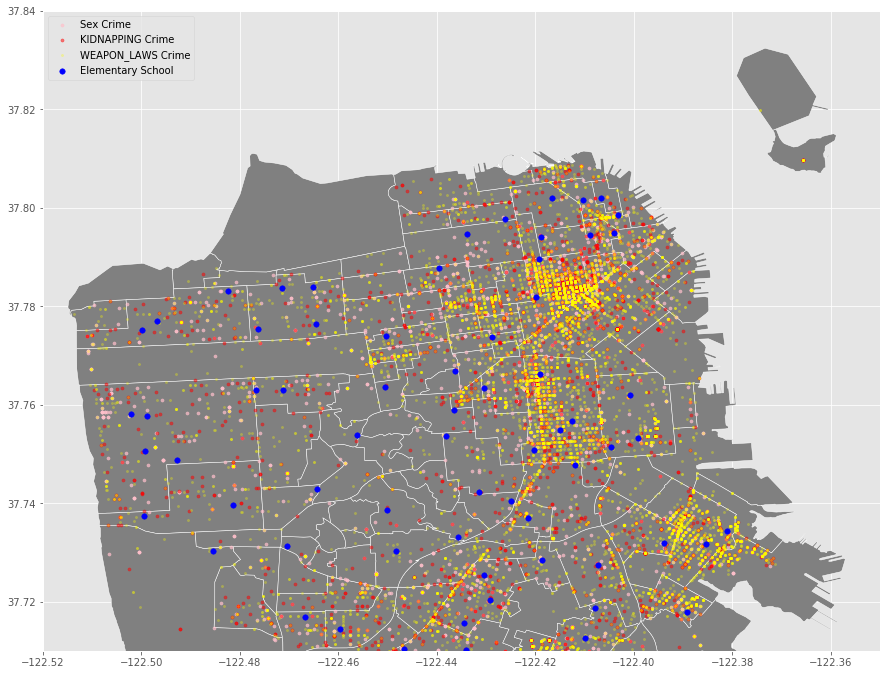

In [229]:
ax = SF_shape.plot(color ="gray" , edgecolor ="white" , figsize = (15, 15))
Sex_Crime.plot(ax= ax, color= 'pink', markersize=10, label= 'Sex Crime', alpha=0.7)
KIDNAPPING_Crime.plot(ax= ax, color= 'red', markersize=10, label= 'KIDNAPPING Crime', alpha=0.5)
WEAPON_LAWS_Crime.plot(ax= ax, color= 'yellow', markersize=5, label= 'WEAPON_LAWS Crime', alpha=0.3)

Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')

plt.legend(loc=2)
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

(37.71, 37.84)

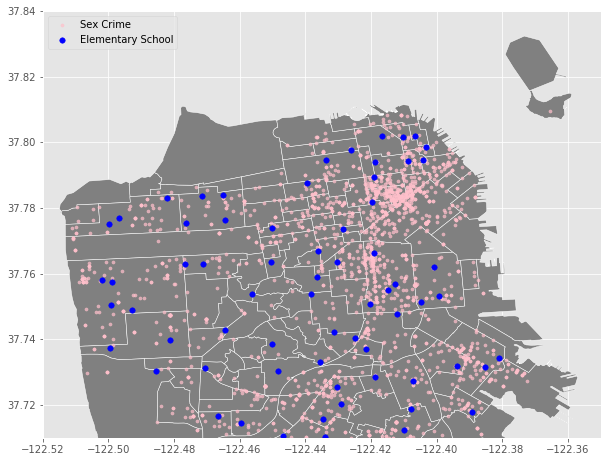

In [231]:
ax = SF_shape.plot(color ="gray" , edgecolor ="white" , figsize = (10, 10))
Sex_Crime.plot(ax= ax, color= 'pink', markersize=10, label= 'Sex Crime', alpha=0.7)
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')

plt.legend(loc=2)
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

(37.71, 37.84)

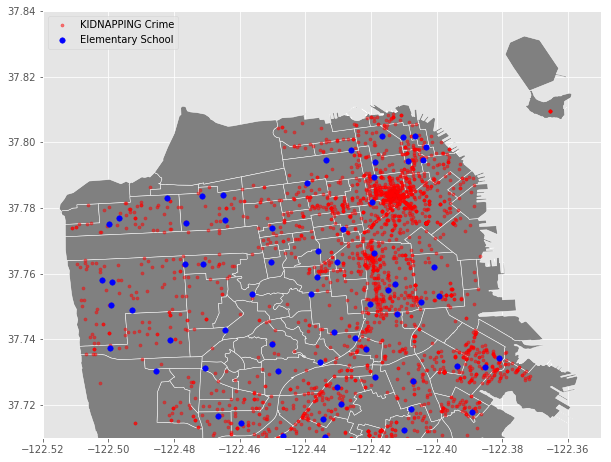

In [232]:
ax = SF_shape.plot(color ="gray" , edgecolor ="white" , figsize = (10, 10))
KIDNAPPING_Crime.plot(ax= ax, color= 'red', markersize=10, label= 'KIDNAPPING Crime', alpha=0.5)
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')

plt.legend(loc=2)
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

(37.71, 37.84)

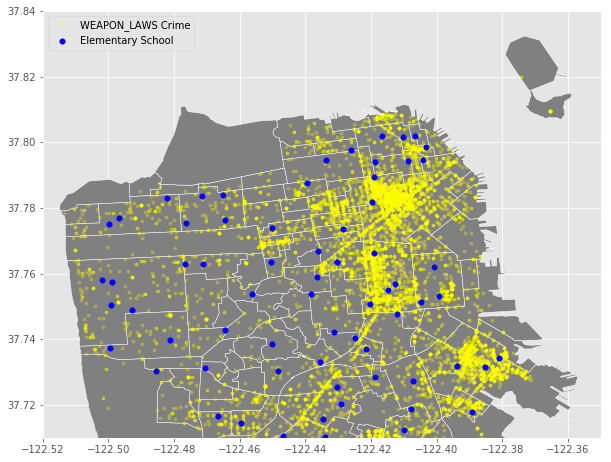

In [235]:
ax = SF_shape.plot(color ="gray" , edgecolor ="white" , figsize = (10, 10))
WEAPON_LAWS_Crime.plot(ax= ax, color= 'yellow', markersize=10, label= 'WEAPON_LAWS Crime', alpha=0.3)
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')

plt.legend(loc=2)
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

#### ANS to "Are the elementary schools in the safe area (that is, the area has lower crime count) ?"
1. The crimes related to sex offenses (pink), kidnapping (red), and weapon laws(yellow) at 10 am -18 pm were selected be investigated. I guess many children might be active around the school during this window of time.
2. The map showed that most of these crimes occurred at SF's financial district, Mission, and Bayview areas.
3. Also, among the three types of crimes, the number of weapon laws crimes are the most.
4. It seems that these crimes had the chance to occur nearby most of the elementary schools. However, the map reveals that elementary schools in central areas of SF were relatively safer.